## Dependencies

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

## Embeddings summary

In [2]:
## Import the embeddings
path = 'data/embeddings.npy'
emb = np.load(path)
print("Embeddings are of the shape {}".format(emb.shape))
print("Column {} is the labels corresponding to each embedding".format(emb.shape[1]))

Embeddings are of the shape (70000, 197)
Column 197 is the labels corresponding to each embedding


# Vanilla KNN on Embeddings

In [12]:
## splitting into test and train embeddings
np.random.seed(42)
idx = np.random.permutation(70000)
emb_train = emb[idx[:60000]]
emb_test = emb[idx[60000:]]

In [14]:
"""
## To-Do
- Try the same on the only the MNIST datasets

- Decide on k values
- Calculate distance of each test instance with database and append to list
- Sort in descending order
- Pick the first 'k' values and assign test emb to majority clas
- Calculate the error

"""
emb_train = emb[idx[:60000]]
emb_test = emb[idx[60000:]]
#emb_test = emb_train
k_test = 100
predictions = dict()

for k in range(1,k_test+1) : predictions[k] = list()

for test_inst in emb_test:

    ## Calculate the distance of each test instance from train instances 
    test_inst = test_inst[:-1]
    test_inst = test_inst.reshape(1,-1)
    test_inst = test_inst.repeat(len(emb_train), axis=0)
    temp_dist = np.linalg.norm((test_inst - emb_train[:,:-1]), axis=1)

    ## Store distance and respective labels in tuples in a list
    temp_dist_idx = [(temp_dist[i],emb_train[i:,-1]) for i in range(len(emb_train))]
    temp_dist_idx.sort()

    for k in range(1,k_test+1):
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_k = temp_dist_idx[:k]
        temp_labels = [digit[1] for digit in temp_first_k]

        ## Pick label that has majority count and append to prediction list
        temp_list = [temp_labels.count(i) for i in temp_labels]
        predictions[k].append(temp_labels[temp_list.index(max(temp_list))])

name = "predictions_knn_newer"
with open(name + '.pkl', 'wb') as f:
    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)

In [15]:
## Calculate accuracy 
accuracy = list()
for k in range(1,k_test+1):
    sim_pred = sum(predictions[k] == emb_test[:,-1])
    accuracy.append((sim_pred/len(emb_test),k))

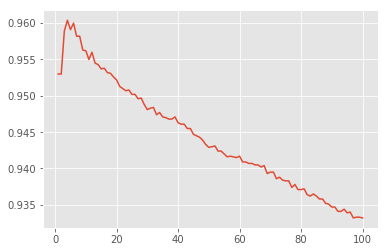

In [16]:
## Plotting accuracy (y_axis) vs K value (x_axis) curve
acc_k = [val[1] for val in accuracy]
acc_val = [val[0] for val in accuracy]

plt.plot(acc_k, acc_val)
plt.show()

In [ ]:
name = "predictions_knn_new"
with open(name + '.pkl', 'wb') as f:
    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)
    
"""
## Load prediciton list 
with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f) """

# CNN on Embeddings

**To use relevant indices, simply unpickle the list 'relevant_idx' and extract corresponding 
rows within the 'train_X' matrix**

In [8]:
def eucl_dist(instance, dataset):
    
    temp_inst = instance.reshape(1,-1)
    temp_inst = temp_inst.repeat(len(dataset), axis=0)
    eucl_dist = np.linalg.norm((temp_inst - dataset[:,:-2]), axis=1)
    eucl_dist_sorted = [(eucl_dist[i], dataset[i,-2]) for i in range(len(dataset))]
    eucl_dist_sorted.sort()
    
    return eucl_dist_sorted


## REMOVING THE BAYESIAN ERROR

In [4]:
"""
- Remove Baysean error
    - Create 2 subsets
    - Find 1NN of instances from subset 1 using subset 2
        - classify them : Delete wrongly classified instances
    -  Find 1NN of instances from subset 2 using subset 1
        - classify them : Delete wrongly classified instances
    - Repeat until stability 
"""

emb = np.load(path)
## Adding indices to the embeddings (to keep track of them)
track_idx = np.array([i for i in range(len(emb))]).reshape(-1,1)
emb = np.concatenate((emb, track_idx), axis = 1)

## Creating subsets for CNN algo
train_subset_1 = emb[:30000]
train_subset_2 = emb[30000:60000]
track_unwanted = list() # store irrelevant indices

stability = False
prev_len_subset_1 = len(train_subset_1)
prev_len_subset_2 = len(train_subset_2)

itr = 0
while not stability:
    
    itr += 1
    print(itr)
    
    temp_unwanted = list()
    
    for n_1,sub_1 in enumerate(train_subset_1):
        
        
        eucl_dist_sorted = eucl_dist(sub_1[:-2], train_subset_2)
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_nn = eucl_dist_sorted[0]
        temp_label = temp_first_nn[1]

        ## Store indices in unwated list if class is wrong
        if temp_label != sub_1[-2]:
            temp_unwanted.append(n_1)
            track_unwanted.append(sub_1[-1])
            
    ## Delete rows of train_subset_1 whose indices lie within the list 'temp_unwanted'  
    train_subset_1 = np.delete(train_subset_1, temp_unwanted, axis=0)
    
    ## Save train_subset_1
    np.save('data/train_subset_1_{}'.format(itr), train_subset_1)
    
    print(itr)
    
    temp_unwanted = list()
    
    for n_2,sub_2 in enumerate(train_subset_2):
        
        eucl_dist_sorted = eucl_dist(sub_2[:-2], train_subset_1)
        
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_nn = eucl_dist_sorted[0]
        temp_label = temp_first_nn[1]
        
        ## Store indices in unwated list if class is wrong
        if temp_label != sub_2[-2]:
            temp_unwanted.append(n_2)
            track_unwanted.append(sub_2[-1])
            
    ## Delete rows of train_subset_1 whose indices lie within the list 'temp_unwanted'  
    train_subset_2 = np.delete(train_subset_2, temp_unwanted, axis=0)
            
    np.save('data/train_subset_2_{}'.format(itr), train_subset_2)
    
    if prev_len_subset_1 == len(train_subset_1) and prev_len_subset_2 == len(train_subset_2):
        stability = True
        
    else: 
        prev_len_subset_1 = len(train_subset_1)
        prev_len_subset_2 = len(train_subset_2)
      
        

1
1
2
2
3
3


In [5]:
train_subset_1 = np.load('data/train_subset_1_3.npy')
train_subset_2 = np.load('data/train_subset_2_3.npy')
print(train_subset_1.shape, train_subset_2.shape)

(28187, 198) (28464, 198)


(56651, 198)

## CONDENSED NEAREST NEIGHBOUR

In [9]:
"""
- Remove instances that can be easily classified
    - Find 1NN neighbours of every instance with every other
    - if class of instance == class of other instance : Delete
    - elif class of instance != class of other instance : Keep
    
"""

## train_subset_1 union train_subset_2 
train_emb_bay = np.concatenate((train_subset_1,train_subset_2), axis = 0)

## Creating storage for relevant instances
random_idx = np.random.choice(len(train_emb_bay),1)
STORAGE = train_emb_bay[random_idx]

stability = False

prev_storage_len = len(STORAGE)
itr = 0 

while not stability:
    
    itr += 1
    print(itr)
    
    for inst in train_emb_bay:
        
        # Calc list sorted by ascending order of euc distance
        eucl_dist_sorted = eucl_dist(inst[:-2], STORAGE)
        
        # Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_nn = eucl_dist_sorted[0]
        temp_label = temp_first_nn[1]
        
        # Store indices in unwated list if class is wrong
        if temp_label != inst[-2]:
            STORAGE = np.concatenate((STORAGE, inst.reshape(1,-1)), axis = 0)
        
        else:continue 
    
    np.save('data/STORAGE_{}'.format(itr), STORAGE)

    if prev_storage_len == len(STORAGE):
        stability = True
    
    else:
        prev_storage_len == len(STORAGE)
            
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


KeyboardInterrupt: 

In [22]:
STORAGE = np.load('data/STORAGE_5.npy')
relevant_idx = list()
for i in range(len(STORAGE)):
    relevant_idx.append(STORAGE[i,-1])

In [24]:
with open("relevant_idx", "wb") as fp:   #Pickling
    pickle.dump(relevant_idx, fp)

"""with open("relevant_idx", "rb") as fp:   # Unpickling
b = pickle.load(fp)"""

'with open("data/relevant_idx", "rb") as fp:   # Unpickling\nb = pickle.load(fp)'

# KNN on strong example after CNN